Now, we'll apply simple machine learning algorithms from the Sci-Kit Learn to find the algorithm that performs the best on this binary classification task

In [4]:
import numpy as np
import pandas as pd
import sklearn.model_selection
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB,ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import sklearn.feature_extraction
from sklearn.svm import SVC
import json
import pickle

# Import and prepare the dataset

In [2]:
# Import the dataset, prepared in "1-Data-Preparation.ipynb"
dataset = pd.read_csv("data/MT-GINCO-split-objectivity-dataset.csv")
dataset.describe()

,text,label,split
count,632,632,632
unique,632,2,2
top,"For the first time since 2008 <p/> Dallas, 12....",subjective,train
freq,1,378,505


In [3]:
dataset.head()

,text,label,split
0,"For the first time since 2008 <p/> Dallas, 12....",subjective,train
1,"17 replies to "" Even in the municipality of Ra...",subjective,train
2,Esimit Europa <p/> Vasili's main sponsor is Es...,subjective,train
3,Beekeepers' successes <p/> The 37th National M...,objective,train
4,Kundalini Yoga <p/> GUIDE <p/> Kundalini Yoga ...,subjective,train


In [4]:
# Create X_train and Y_train parts, used for sci kit learning
train_df = dataset[dataset["split"] == "train"]
X_train = list(train_df.text)
Y_train = list(train_df.label)

test_df = dataset[dataset["split"] == "test"]
X_test = list(test_df.text)
Y_test = list(test_df.label)

print(len(X_test), len(Y_test))

127 127


In [5]:
labels = list(dataset.label.unique())
labels

['subjective', 'objective']

In [6]:
# Create a TF-IDF representation of the text
def data_iterator(f):
    for token in f:
        yield token


def tokenizer(txt):
    """Simple whitespace tokenizer"""
    return txt.split()

iterator=data_iterator(X_train)
test_iterator=data_iterator(X_test)

vectorizer=sklearn.feature_extraction.text.TfidfVectorizer(tokenizer=tokenizer,use_idf=True,min_df=0.005)

d=vectorizer.fit_transform(iterator)

d_test=vectorizer.transform(test_iterator)

In [7]:
pickle.dump(vectorizer, open("vectorizer.pickle", "wb")) #Save vectorizer

In [ ]:
print(X_test)

# Sci-Kit Models

In [12]:
# Create a pipeline of models that you want to try:

pipelines=[]

for model in [DummyClassifier(strategy="most_frequent"), DummyClassifier(strategy="stratified"), DecisionTreeClassifier(), MultinomialNB(), ComplementNB(), LogisticRegression(solver='saga'), SVC(C=0.5,kernel='linear',shrinking=False,probability=True),RandomForestClassifier()]:
    pipeline=make_pipeline(model)
    pipelines.append(pipeline)

In [13]:
pipelines

[Pipeline(steps=[('dummyclassifier', DummyClassifier(strategy='most_frequent'))]),
 Pipeline(steps=[('dummyclassifier', DummyClassifier(strategy='stratified'))]),
 Pipeline(steps=[('decisiontreeclassifier', DecisionTreeClassifier())]),
 Pipeline(steps=[('multinomialnb', MultinomialNB())]),
 Pipeline(steps=[('complementnb', ComplementNB())]),
 Pipeline(steps=[('logisticregression', LogisticRegression(solver='saga'))]),
 Pipeline(steps=[('svc',
                  SVC(C=0.5, kernel='linear', probability=True,
                      shrinking=False))]),
 Pipeline(steps=[('randomforestclassifier', RandomForestClassifier())])]

In [14]:
#Training the model
# To be able to deploy the model, we need to save it with Pickle

import time
training_time=[]

for i, pipeline in enumerate(pipelines):
    start=time.time()
    pipeline.fit(d, Y_train)
    stop=time.time()
    pickle.dump(pipeline, open(f'{pipelines[i].steps[0][0].upper()}.pkl','wb'))
    training_time.append(stop-start)

In [11]:
#Prediction from test dataset
model_name=[]
y_pred_list = []
micro_f1_array=[]
macro_f1_array = []
accuracy_array = []
test_time=[]

print("Classifiation Report\n")
print("*****************************************************")
for i, pipeline in enumerate(pipelines):
    start=time.time()
    y_pred=pipeline.predict(d_test)
    y_pred_list.append(list(y_pred))
    stop=time.time()
    test_time.append(stop-start)
    print(pipelines[i].steps[0][0].upper())
    model_name.append(pipelines[i].steps[0][0].upper())

    micro_f1_array.append(round(f1_score(Y_test, y_pred, labels=labels, average ="micro"),3))
    macro_f1_array.append(round(f1_score(Y_test, y_pred, labels=labels, average ="macro"),3))
    accuracy_array.append(round(metrics.accuracy_score(Y_test, y_pred),3))
    print("\n",classification_report(Y_test, y_pred, zero_division = 0))
    print("*****************************************************")

results = {"model":model_name, "microF1": micro_f1_array, "macroF1":macro_f1_array, "accuracy":accuracy_array, "y_pred":y_pred_list}

Classifiation Report

*****************************************************
DUMMYCLASSIFIER

               precision    recall  f1-score   support

   objective       0.00      0.00      0.00        51
  subjective       0.60      1.00      0.75        76

    accuracy                           0.60       127
   macro avg       0.30      0.50      0.37       127
weighted avg       0.36      0.60      0.45       127

*****************************************************
DUMMYCLASSIFIER

               precision    recall  f1-score   support

   objective       0.40      0.39      0.40        51
  subjective       0.60      0.61      0.60        76

    accuracy                           0.52       127
   macro avg       0.50      0.50      0.50       127
weighted avg       0.52      0.52      0.52       127

*****************************************************
DECISIONTREECLASSIFIER

               precision    recall  f1-score   support

   objective       0.60      0.59      0.59   

In [15]:
SVC_model = pickle.load(open('models-and-flask-app/SVC.pkl', 'rb'))

test_iterator=data_iterator(["She's great."])

d_test=vectorizer.transform(test_iterator)

SVC_prediction = SVC_model.predict(d_test)  # this returns a list e.g. [127.20488798], so pick first element [0]
SVC_output = SVC_prediction[0] 

In [16]:
# Get probabilities for both classes
SVC_probabilities = SVC_model.predict_proba(d_test)
SVC_probabilities

array([[0.36870557, 0.63129443]])

In [20]:
round(SVC_probabilities[0][1],2)

0.63

In [12]:
results

{'model': ['DUMMYCLASSIFIER',
  'DUMMYCLASSIFIER',
  'DECISIONTREECLASSIFIER',
  'MULTINOMIALNB',
  'COMPLEMENTNB',
  'LOGISTICREGRESSION',
  'SVC',
  'RANDOMFORESTCLASSIFIER'],
 'microF1': [0.598, 0.52, 0.677, 0.669, 0.693, 0.74, 0.732, 0.78],
 'macroF1': [0.374, 0.499, 0.663, 0.542, 0.612, 0.697, 0.69, 0.748],
 'accuracy': [0.598, 0.52, 0.677, 0.669, 0.693, 0.74, 0.732, 0.78],
 'y_pred': [['subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjective',
   'subjectiv

In [26]:
results_df = pd.DataFrame(results)
results_df

,model,microF1,macroF1,accuracy,y_pred
0,DUMMYCLASSIFIER,0.598,0.374,0.598,"[subjective, subjective, subjective, subjectiv..."
1,DUMMYCLASSIFIER,0.520,0.505,0.520,"[objective, subjective, objective, subjective,..."
2,DECISIONTREECLASSIFIER,0.693,0.677,0.693,"[subjective, subjective, subjective, objective..."
3,MULTINOMIALNB,0.669,0.542,0.669,"[subjective, subjective, subjective, objective..."
4,COMPLEMENTNB,0.693,0.612,0.693,"[subjective, subjective, subjective, objective..."
5,LOGISTICREGRESSION,0.740,0.697,0.740,"[subjective, subjective, subjective, objective..."
6,SVC,0.732,0.690,0.732,"[subjective, subjective, subjective, objective..."
7,RANDOMFORESTCLASSIFIER,0.748,0.712,0.748,"[subjective, subjective, subjective, objective..."


In [53]:
y_model_pred = extended_results[extended_results["model"] == "FastText"].y_pred
y_model_pred

8    [subjective, subjective, subjective, objective...
Name: y_pred, dtype: object

([<matplotlib.axis.XTick at 0x23b14cb7fa0>,
 [Text(0, 0, 'subjective'), Text(1, 0, 'objective')])

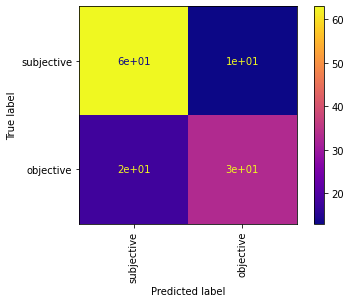

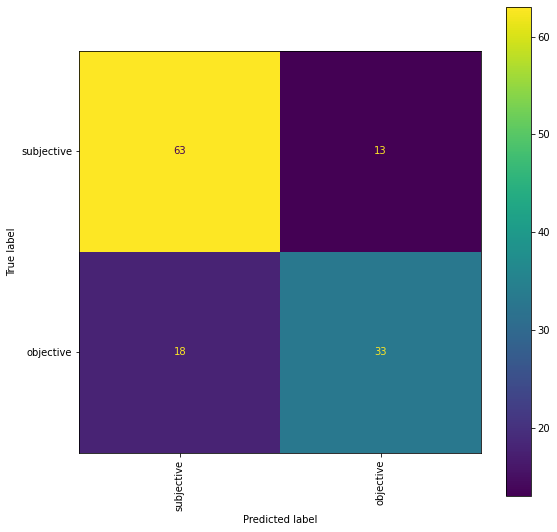

In [54]:
# Plot the confusion matrix for the desired model. You can normalise the values with the attribute "normalize":
# "true" - normalize across rows, "all" = normalize by total no. of samples,
# "pred" - normalize across columns

y_model_pred = list(extended_results[extended_results["model"] == "FastText"].y_pred)[0]

dp = ConfusionMatrixDisplay.from_predictions(list(Y_test), y_model_pred, labels = labels, xticks_rotation=90, cmap='plasma', colorbar=True, values_format=".1g")

# To make the plot bigger:
fig, ax = plt.subplots(figsize=(9,9))
dp.plot(ax=ax)
plt.xticks(np.arange(len(labels)), labels, rotation=90)

As we can see, the SVC and Logistic Regression perform the best on this task.

# FastText

The training was performed on Google Collab in "3-FastText-Experiments.ipynb".

In [41]:
#Append the results from FastText learning into these results:
ft_results = json.load(open("data/fastText_results.json"))

In [44]:
# Create a new lists of predicted labels, by changing the fasttext labels into labels that are used in scikit experiments
y_pred_new = []

for i in ft_results["y_pred"]:
    y_pred_new.append(i.replace("__label__", ""))

In [45]:
# Create a dataframe with FastText results
ft_dataframe = pd.DataFrame({"model": ft_results["model"],"microF1":ft_results["microF1"], "macroF1": ft_results["macroF1"],"accuracy": ft_results["accuracy"],"y_pred":[y_pred_new]})
ft_dataframe

,model,microF1,macroF1,accuracy,y_pred
0,FastText,0.756,0.741,0.756,"[subjective, subjective, subjective, objective..."


In [47]:
# Append the dataframe to all results
extended_results = pd.concat([results_df,ft_dataframe], ignore_index = True)

extended_results

,model,microF1,macroF1,accuracy,y_pred
0,DUMMYCLASSIFIER,0.598,0.374,0.598,"[subjective, subjective, subjective, subjectiv..."
1,DUMMYCLASSIFIER,0.520,0.505,0.520,"[objective, subjective, objective, subjective,..."
2,DECISIONTREECLASSIFIER,0.693,0.677,0.693,"[subjective, subjective, subjective, objective..."
3,MULTINOMIALNB,0.669,0.542,0.669,"[subjective, subjective, subjective, objective..."
4,COMPLEMENTNB,0.693,0.612,0.693,"[subjective, subjective, subjective, objective..."
5,LOGISTICREGRESSION,0.740,0.697,0.740,"[subjective, subjective, subjective, objective..."
6,SVC,0.732,0.690,0.732,"[subjective, subjective, subjective, objective..."
7,RANDOMFORESTCLASSIFIER,0.748,0.712,0.748,"[subjective, subjective, subjective, objective..."
8,FastText,0.756,0.741,0.756,"[subjective, subjective, subjective, objective..."


In [58]:
# Save the results file
extended_results.to_csv("ML_experiments_results.csv", index=False)

In [5]:
extended_results = pd.read_csv("ML_experiments_results.csv")
extended_results

,model,microF1,macroF1,accuracy,y_pred
0,DUMMYCLASSIFIER,0.598,0.374,0.598,"['subjective', 'subjective', 'subjective', 'su..."
1,DUMMYCLASSIFIER,0.520,0.505,0.520,"['objective', 'subjective', 'objective', 'subj..."
2,DECISIONTREECLASSIFIER,0.693,0.677,0.693,"['subjective', 'subjective', 'subjective', 'ob..."
3,MULTINOMIALNB,0.669,0.542,0.669,"['subjective', 'subjective', 'subjective', 'ob..."
4,COMPLEMENTNB,0.693,0.612,0.693,"['subjective', 'subjective', 'subjective', 'ob..."
5,LOGISTICREGRESSION,0.740,0.697,0.740,"['subjective', 'subjective', 'subjective', 'ob..."
6,SVC,0.732,0.690,0.732,"['subjective', 'subjective', 'subjective', 'ob..."
7,RANDOMFORESTCLASSIFIER,0.748,0.712,0.748,"['subjective', 'subjective', 'subjective', 'ob..."
8,FastText,0.756,0.741,0.756,"['subjective', 'subjective', 'subjective', 'ob..."


In [19]:
# Create a dictionary from the dataset to be able to save it to json
results_dict = extended_results.to_dict("records")
results_dict

[{'model': 'DUMMYCLASSIFIER',
  'microF1': 0.598,
  'macroF1': 0.374,
  'accuracy': 0.598,
  'y_pred': "['subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective', 'subjective',

In [21]:
# Save the results in a json format
with open("data&results/ML_experiments_results.json","w") as results_file:
    json.dump(results_dict, results_file)